In [1]:
#import library
import numpy as np
import pandas as pd
from datetime import date
from neupy import algorithms
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import keras
from keras import regularizers
import pyrenn as prn
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#constant 
path = '2016_spring/2016_spring{}.csv'
yield_path = '2016_spring/2016_spring.csv'
file_parameters = ['CC', 'CV', 'CH', 'ExG']

# Read files

# Functions

In [3]:
#count day after planting
def countDaysAfterPlanting(date_planting, date_key):
#     print(date_planting, date_key)
    f_date_array = date_planting.split('-')
    f_date = date(int(f_date_array[2]), int(f_date_array[0]), int(f_date_array[1]))
    l_date = ''.join(s for s in date_key if s.isdigit())
    #print(int('20'+l_date[:2]), int(l_date[2:4]), int(l_date[4:6]))
    l_date = date(int('20'+l_date[:2]), int(l_date[2:4]), int(l_date[4:6]))
    return(abs((l_date-f_date).days))

# Build Models

In [4]:
#build model that have 2 hidden layers (64, 64)
def buildRegressionModel(model_shape, input_shape, optimizer, loss, metrics, drop_out=None, regularizer_l1=None, regularizer_l2=None, kernel_initializer = 'uniform', drop_out_rate = 0.25):

    # Define a Keras sequential model
    model = keras.Sequential()
    # Define the first dense layer
    for (i, size) in enumerate(model_shape):
        if i ==0:
            model.add(keras.layers.Dense(size, activation='relu', input_shape=[input_shape], kernel_regularizer=regularizer_l2,
                        activity_regularizer=regularizer_l1, kernel_initializer=kernel_initializer))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
        else:
            model.add(keras.layers.Dense(size, activation='relu', kernel_regularizer=regularizer_l2, kernel_initializer=kernel_initializer,
                        activity_regularizer=regularizer_l1))
            if drop_out:
                model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1, kernel_initializer=kernel_initializer))
    
    #compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [61]:
def trainModel(x_data, y_data, input_shape, parameters):    
    #Build Hypterparameter
    sizes = parameters['sizes'] 
    shapes = parameters['shapes']
    drop_out = parameters['drop_out'] 
    regularizer_l1 = parameters['regularizer_l1']
    regularizer_l2 = parameters['regularizer_l2']
    kernel_initializer = parameters['kernel_initializer']
    drop_out_rate = parameters['drop_out_rate']
    #Compile Hyperparameter
    optimizer = parameters['optimizer']
    #optimizer = keras.optimizers.RMSprop(0.001)
    loss = parameters['loss']
    #loss = 'mae'
    metrics = parameters['metrics']

    #Callback Hyperparameter
    early_stopping = parameters['early_stopping']
    if early_stopping:
        callbacks = [early_stopping]
    else:
        callbacks = None
    verbose = parameters['verbose']
    
    #Train Hyperparameter
    epochs = parameters['epochs']
    validation_split = parameters['validation_split'] 
    
    #Test Train Split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state = 90)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state = 90)
    
    history ={}
    model = {}
    #build and train model
    for (i, size) in enumerate(sizes):
        model[size] = buildRegressionModel(shapes[i], input_shape, optimizer, loss, metrics, drop_out = drop_out, kernel_initializer = kernel_initializer, 
                                     regularizer_l1=regularizer_l1, regularizer_l2 =regularizer_l2)
        history[size] = model[size].fit(x_train, y_train, epochs=epochs, validation_data=(x_valid, y_valid), 
                                  callbacks = callbacks, verbose = verbose)
        
        
    #plot results
    colors = ['red', 'blue', 'green', 'yellow']
    plt.figure()
    for i, size in enumerate(sizes):
        data_history = history[size].history
        loss = data_history['loss']
        val_loss = data_history['val_loss']
        plt.plot(val_loss, color=colors[i], linestyle = '--', label = size + '_val_loss')
        plt.plot(loss, color=colors[i], linestyle = ':', label = size +'_loss')
    
    plt.legend(loc = 'upper left' )
    plt.xlabel = 'epochs'
    plt.ylabel = 'loss'
    
    
    #Show R2 scores
    for i, size in enumerate(sizes):
        #train score
        pred_train = model[size].predict(x_train)
        train_compare = pd.DataFrame({'y_train': y_train.flatten(), 'y_train_pred': pred_train.flatten()})
        train_r2_score = r2_score(train_compare.y_train, train_compare.y_train_pred)
        print(size + ' train r2 score = ', train_r2_score, '/ 1.0')
        
        #test score
        pred_test = model[size].predict(x_test)
        test_compare = pd.DataFrame({'y_test': y_test.flatten(), 'y_test_pred': pred_test.flatten()})
        test_r2_score = r2_score(test_compare.y_test, test_compare.y_test_pred)
        print(size+' test r2 score = ', test_r2_score, '/ 1.0')

# prepare Data

# Cotton Yield data

In [6]:
def CottonYieldData():
    canopy_dataframe = pd.read_excel('X.xlsx')
    canopy_dataframe = canopy_dataframe.reindex(np.random.permutation(canopy_dataframe.index))
    canopy_dataframe.head()
    
    x = canopy_dataframe.loc[:, canopy_dataframe.columns != 'target' ].values
#     print(x.shape)
    
    y = canopy_dataframe['target'].values
#     print(y.shape)
    return (x, y)

# Tomato Yield data

In [8]:
def GRNN_process(row_data, days_after_planting, x_pred, std):
#     print(row_data.shape)
#     print(days_after_planting.shape)
    if (days_after_planting[0] != 0):
        days_after_planting = np.append([0], days_after_planting, axis = 0)
        row_data = np.append([0], row_data, axis = 0)
    grnn = algorithms.GRNN(std = std)
    grnn.train(days_after_planting, row_data)
    result = grnn.predict(x_pred)
    result = result.swapaxes(0,1)
    
#     print(result)
    return result

In [189]:
def tomatoYieldData(parameters):
     #hypter parameter
    std = parameters['std']
    normalization = parameters['normalization']
    interval_day = parameters['interval_day']
    limit_day = parameters['limit_day']
    
    original_data = []
    yield_data = pd.read_csv(path.format(''))
    plant_day = yield_data['plantDate']
    interval_process_data = np.empty([len(yield_data), 0])
    x_pred = range(interval_day, limit_day+1, interval_day)
    
   
    
    
    #read data, keep Id and date keys only
    for i in range(len(file_parameters)):
        temp = pd.read_csv(path.format('_'+file_parameters[i]))
    #     print(column_name for column_name in temp.columns if parameter[i] in column_name)
#         print([x for x in temp.columns if file_parameters[i] in x and len(x) == len(file_parameters[i]) + 6])
        temp = temp[[x for x in temp.columns if file_parameters[i] in x and len(x) == len(file_parameters[i]) + 6]]
        original_data.append(temp)
    
    for i in range(len(file_parameters)):
        parameter_data = original_data[i]
        date_keys = parameter_data.columns
        interval_process_parameter_data = np.empty([0, len(x_pred)])
        for row in range(len(parameter_data)):           
            row_data = parameter_data.loc[row].values
            plant_date = plant_day[row]
            days_after_planting = np.array([countDaysAfterPlanting(plant_date, date_key) for date_key in date_keys])
            mask = (days_after_planting >=0) & (days_after_planting<=limit_day) & (row_data>0)
#             print(row_data)
            row_data = row_data[mask]
#             print(days_after_planting)
#             print(mask.shape)
            days_after_planting = days_after_planting[mask]
            GRNN_data = GRNN_process(row_data, days_after_planting, x_pred, std)
            interval_process_parameter_data = np.append(interval_process_parameter_data, GRNN_data, axis = 0)

        if normalization:
            interval_process_parameter_data /= np.linalg.norm(interval_process_parameter_data)
        interval_process_data = np.append(interval_process_data, interval_process_parameter_data, axis = 1)

    #Added one hot of plantDate
    test_plant_date = pd.DataFrame(yield_data['plantDate'])
    test_plant_data_values = np.unique(yield_data['plantDate'].values)
    test_plant_date['plantDate'] = test_plant_date['plantDate'].map(lambda x: {date:i for (i, date) in enumerate(test_plant_data_values)}.get(x))
    test_plant_date = pd.get_dummies(test_plant_date['plantDate'])
    interval_process_data = np.append(interval_process_data, test_plant_date.values, axis = 1)
    
    x_train = interval_process_data 
    y_train = yield_data['Yield'].values
#     print(y_train.shape)
#     print(x_train.shape)
    return(x_train, y_train)
        

# Tomato Yield planting in 2/28/2016 data

In [87]:
def tomatoYieldDateChosenData(parameters):
    original_data = []
    yield_data = pd.read_csv(path.format(''))
    plant_day = yield_data['plantDate']
    
    
    x_pred = range(interval_day, limit_day+1, interval_day)
    
    #hypter parameter
    std = parameters['std']
    normalization = parameters['normalization']
    date_chosen = parameters['date_chosen']
    grnn = parameters['grnn']
    
    
    yield_mask = plant_day.values == date_chosen
    interval_process_data = np.empty([sum(yield_mask), 0])
#     print(interval_process_data.shape)
    #read data, keep Id and date keys only
    for i in range(len(file_parameters)):
        temp = pd.read_csv(path.format('_'+file_parameters[i]))
    #     print(column_name for column_name in temp.columns if parameter[i] in column_name)
        temp = temp[[x for x in temp.columns if file_parameters[i] in x and len(x) == len(file_parameters[i]) + 6]]
        temp= temp[yield_mask]
        original_data.append(temp)
    
    for i in range(len(file_parameters)):
        parameter_data = original_data[i]
        date_keys = parameter_data.columns
        interval_process_parameter_data = np.empty([0, len(x_pred)])
        for row in range(len(parameter_data)):           
            row_data = parameter_data.loc[row].values
            plant_date = plant_day[row]
            days_after_planting = np.array([countDaysAfterPlanting(plant_date, date_key) for date_key in date_keys])
            mask = (days_after_planting >=0) & (days_after_planting<=limit_day) & (row_data>0)
#             print(row_data)
            row_data = row_data[mask]
#             print(days_after_planting)
#             print(mask.shape)
            days_after_planting = days_after_planting[mask]
            if grnn:
                GRNN_data = GRNN_process(row_data, days_after_planting, x_pred, std)
            else: GRNN_data = row_data
            interval_process_parameter_data = np.append(interval_process_parameter_data, GRNN_data, axis = 0)

        if normalization:
            interval_process_parameter_data /= np.linalg.norm(interval_process_parameter_data)
        interval_process_data = np.append(interval_process_data, interval_process_parameter_data, axis = 1)

    #Added one hot of plantDate
#     test_plant_date = pd.DataFrame(yield_data['plantDate'])
#     test_plant_data_values = np.unique(yield_data['plantDate'].values)
#     test_plant_date['plantDate'] = test_plant_date['plantDate'].map(lambda x: {date:i for (i, date) in enumerate(test_plant_data_values)}.get(x))
#     test_plant_date = pd.get_dummies(test_plant_date['plantDate'])
#     interval_process_data = np.append(interval_process_data, test_plant_date.values, axis = 1)
    
    x_train = interval_process_data 
    y_train = yield_data['Yield'].values[yield_mask]
#     print(y_train.shape)
#     print(x_train.shape)
    return(x_train, y_train)

# Test GRNN model

In [178]:
data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['interval_day'] = 10
data_parameters['limit_day'] = 80
predict_days = range(data_parameters['interval_day'], data_parameters['limit_day']+1, data_parameters['interval_day'])
x_predict, y_predict = tomatoYieldData(data_parameters)

In [190]:
data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['interval_day'] = 1
data_parameters['limit_day'] = 80
all_days = range(data_parameters['interval_day'], data_parameters['limit_day']+1, data_parameters['interval_day'])
x_all_days, y_predict = tomatoYieldData(data_parameters)

print(x_all_days.shape)

(243, 323)


In [155]:
 #hypter parameter
std = parameters['std']
normalization = parameters['normalization']
interval_day = parameters['interval_day']
limit_day = parameters['limit_day']

original_data = []
yield_data = pd.read_csv(path.format(''))
plant_day = yield_data['plantDate']
interval_process_data = np.empty([len(yield_data), 0])
x_pred = range(interval_day, limit_day+1, interval_day)
original_days = []



#read data, keep Id and date keys only
for i in range(len(file_parameters)):
    temp = pd.read_csv(path.format('_'+file_parameters[i]))
#     print(column_name for column_name in temp.columns if parameter[i] in column_name)
#         print([x for x in temp.columns if file_parameters[i] in x and len(x) == len(file_parameters[i]) + 6])
    temp = temp[[x for x in temp.columns if file_parameters[i] in x and len(x) == len(file_parameters[i]) + 6]]
    original_data.append(temp)

for i in range(len(file_parameters)):
    parameter_data = original_data[i]
    date_keys = parameter_data.columns
    interval_process_parameter_data = np.empty([0, len(x_pred)])
    for row in range(len(parameter_data)):           
        row_data = parameter_data.loc[row].values
        plant_date = plant_day[row]
        days_after_planting = np.array([countDaysAfterPlanting(plant_date, date_key) for date_key in date_keys])
        mask = (days_after_planting >=0) & (days_after_planting<=limit_day) & (row_data>0)
#             print(row_data)
        row_data = row_data[mask]
#             print(days_after_planting)
#             print(mask.shape)
        days_after_planting = days_after_planting[mask]
        original_days.append(days_after_planting)
        GRNN_data = GRNN_process(row_data, days_after_planting, x_pred, std)
        interval_process_parameter_data = np.append(interval_process_parameter_data, row_data, axis = 0)

    if normalization:
        interval_process_parameter_data /= np.linalg.norm(interval_process_parameter_data)
    interval_process_data = np.append(interval_process_data, interval_process_parameter_data, axis = 1)
x_train = interval_process_data 
y_train = yield_data['Yield'].values
#     print(y_train.shape)
#     print(x_train.shape)
return(x_train, y_train)


In [161]:
def show_GRNN_examples(observation, data_parameters):
    interval_day = data_parameters['interval_day']
    limit_day = data_parameters['limit_day']
    normalization = data_parameters['normalization']
    std = data_parameters['std']
    
    
    yield_data = pd.read_csv(path.format(''))
    plant_day = yield_data['plantDate']
    
    all_days = range(0, limit_day+1)
    predict_days = range(interval_day, limit_day+1, interval_day)
    
    count = 0
    
    #create plot
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
    fig.suptitle('Observation id:{}, Yield:{}\n'.format(yield_data['id'][observation], yield_data['Yield'][observation]),  fontsize= 30)
    
    for (i, file_parameter) in enumerate(file_parameters):
        parameter_data = original_data[i].iloc[observation]
        date_keys = original_data[i].columns
                  
        row_data = parameter_data.values
        plant_date = plant_day[observation]
        days_after_planting = np.array([countDaysAfterPlanting(plant_date, date_key) for date_key in date_keys])
        mask = (days_after_planting >=0) & (days_after_planting<=limit_day) & (row_data>0)
#             print(row_data)
        row_data = row_data[mask]
#             print(days_after_planting)
#             print(mask.shape)


        original_days = days_after_planting[mask]
        
        value_original_days = original_data[i].loc[observation].values[mask]
        value_predict_days = x_train[observation][count:count+len(predict_days)]
        count+=len(predict_days)
#         print(len(predict_days))
#         print(value_predict_days.shape)
        
        
        value_all_days = GRNN_process(row_data, original_days, all_days, std)[0]
#         print(all_days.shape)
#         print(value_all_days.shape)
        
        #plot value and days
        axs[i//2, i%2].plot(all_days, value_all_days)
        axs[i//2, i%2].scatter(original_days, value_original_days, color='red', label ='original')
        axs[i//2, i%2].scatter(predict_days, value_predict_days, color='blue', label='predicted')
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_ylabel(file_parameter+' values')
        axs[i//2, i%2].set_xlabel('Days after planting')
        axs[i//2, i%2].set_title(file_parameter)

    plt.show()
        
    

In [191]:
def show_GRNN_normalization_examples(observation, data_parameters):
    
    count_predict = 0
    count_all_days = 0
    
    yield_data = pd.read_csv(path.format(''))
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 6))
    fig.suptitle('Observation id:{}, Yield:{}\n'.format(yield_data['id'][observation], yield_data['Yield'][observation]),  fontsize= 30)
    for (i, file_parameter) in enumerate(file_parameters):
        value_predict_days = x_predict[observation][count_predict:count_predict+len(predict_days)]
        count_predict+=len(predict_days)

        value_all_days = x_all_days[observation][count_all_days:count_all_days+len(all_days)]
        count_all_days+=len(all_days)

        #plot value and days
        axs[i//2, i%2].plot(all_days, value_all_days)
        
        axs[i//2, i%2].scatter(predict_days, value_predict_days, color='blue', label='predicted')
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_ylabel(file_parameter+' values')
        axs[i//2, i%2].set_xlabel('Days after planting')
        axs[i//2, i%2].set_title(file_parameter)

    plt.show()
        
    

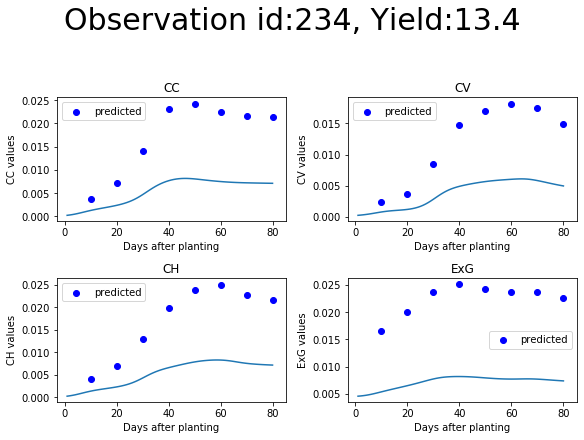

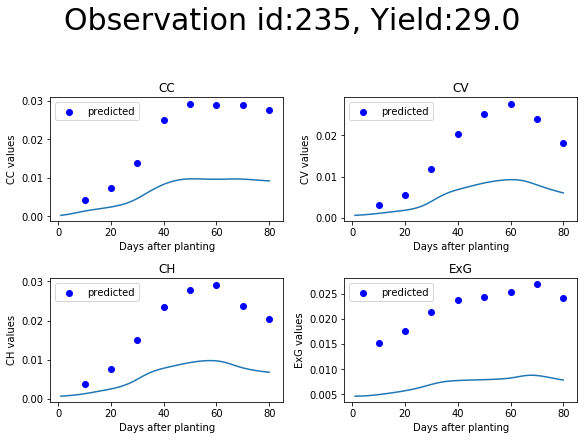

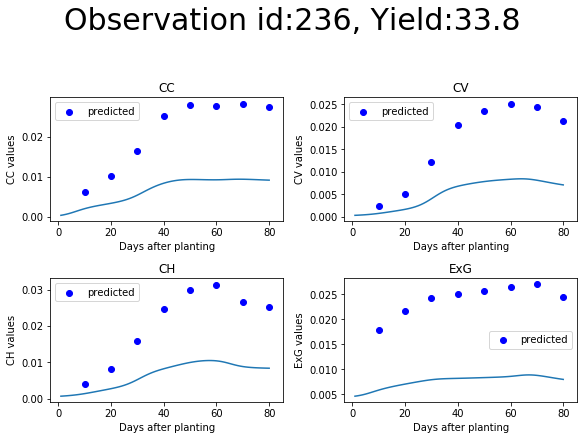

In [192]:
observation = 4
data_parameters = {}
data_parameters['normalization'] = False
data_parameters['std'] = 10
data_parameters['interval_day'] = 10

data_parameters['limit_day'] = 80
data_parameters['interval_day'] = 10

observations = range(233, 236)
for observation in observations:
    show_GRNN_normalization_examples(observation, data_parameters)

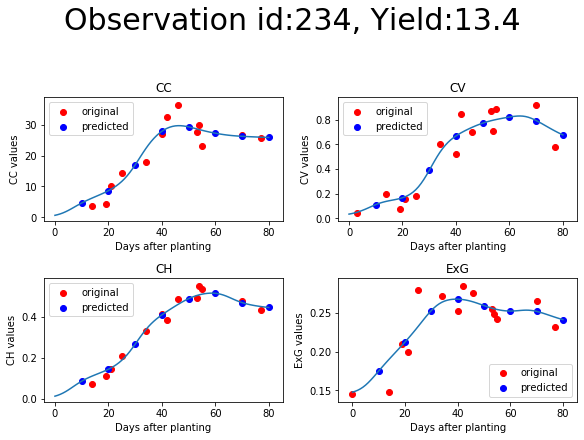

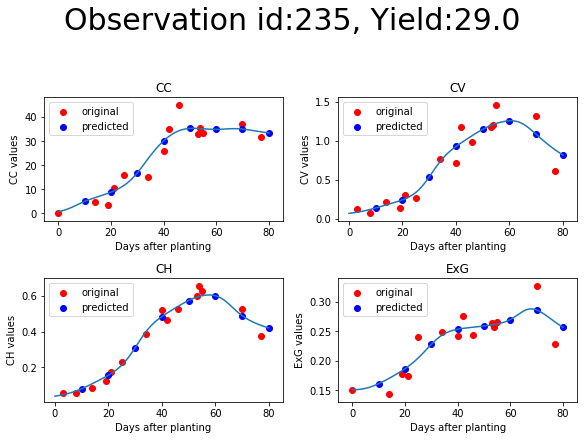

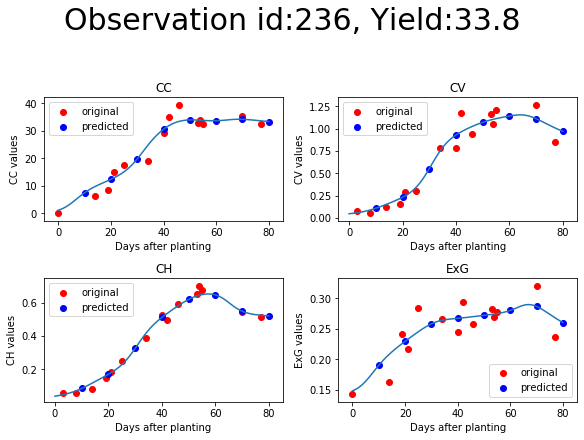

In [193]:
observation = 4
data_parameters = {}
data_parameters['normalization'] = False
data_parameters['std'] = 10
data_parameters['interval_day'] = 10

data_parameters['limit_day'] = 80
data_parameters['interval_day'] = 10

observations = range(233, 236)
for observation in observations:
    show_GRNN_examples(observation, data_parameters)

In [119]:
original_data[1].loc[2]

CV160323    0.056418
CV160328    0.355411
CV160329   -0.040584
CV160331   -1.531215
CV160414    0.324445
CV160419    0.805503
CV160421    0.813759
CV160425    0.836444
CV160504    0.977630
CV160510    0.757555
CV160512    0.930642
CV160516    0.892701
CV160523    0.791252
CV160524    0.885647
CV160525    0.844500
CV160609    0.558831
CV160616    0.443329
CV160622    0.839380
Name: 2, dtype: float64

# Process

In [57]:
def process(model_parameters, data_parameters, data_func):
    
    x_data, y_data = data_func(data_parameters)
    trainModel(x_data, y_data, x_data.shape[1], model_parameters)

# Test multiple Models

default train r2 score =  0.6014696159800672 / 1.0
default test r2 score =  0.40876908461720274 / 1.0
medium train r2 score =  0.7203084369029642 / 1.0
medium test r2 score =  0.28110200830575305 / 1.0
small train r2 score =  0.5838711084873871 / 1.0
small test r2 score =  0.39575403829767464 / 1.0
tiny train r2 score =  0.7209424960750649 / 1.0
tiny test r2 score =  0.24316955308407684 / 1.0


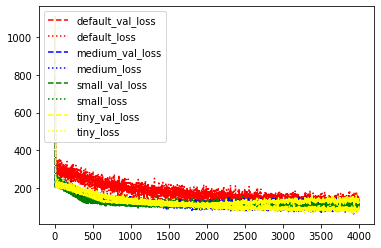

In [195]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default']
parameters['shapes'] = [[64, 64, 64, 64, 4], [64, 64, 64, 64], [64,64, 64, 64, 64], [64, 64, 64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = True
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = None
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.01

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
#optimizer = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.0001
parameters['patience'] = 1000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 4000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = '2-28-2016'
data_parameters['grnn'] = True
data_parameters['interval_day'] = 10
data_parameters['limit_day'] = 80
# data_parameters['grnn'] = False

#data Type
data_func = tomatoYieldData

process(parameters, data_parameters, data_func)

# Test single model

In [196]:
parameters = {}    
#Build Hypterparameter
parameters['sizes'] = ['default', 'medium', 'small', 'tiny']
# parameters['sizes'] = ['default']
parameters['shapes'] = [[64, 64, 64, 64, 4], [64, 64, 64, 64], [64,64, 64, 64, 64], [64, 64, 64]]
# parameters['shapes'] = [[16,16]]
parameters['drop_out'] = False
parameters['regularizer_l1'] = None
parameters['regularizer_l2'] = regularizers.l2(0.00001)
parameters['kernel_initializer'] = 'uniform'
parameters['drop_out_rate'] = 0.01

#Compile Hyperparameter
parameters['optimizer'] = 'adam'
#optimizer = keras.optimizers.RMSprop(0.001)
parameters['loss'] = 'mse'
#loss = 'mae'
parameters['metrics'] = ['mse']

#Callback Hyperparameter
parameters['monitor'] = 'val_loss'
parameters['min_delta'] = 0.0001
parameters['patience'] = 1000
parameters['mode'] = 'min'
parameters['verbose'] = 0
parameters['restore_best_weights'] = True
# parameters['early_stopping'] = EarlyStopping(monitor=parameters['monitor'], min_delta=parameters['min_delta'], patience=parameters['patience'], mode=parameters['mode'], verbose=parameters['verbose'] , restore_best_weights = parameters['restore_best_weights'])
parameters['early_stopping'] = None

#Train Hyperparameter
parameters['epochs'] = 4000
parameters['validation_split'] = 0.2

data_parameters = {}
data_parameters['normalization'] = True
data_parameters['std'] = 10
data_parameters['date_chosen'] = '2-28-2016'
data_parameters['grnn'] = True
data_parameters['interval_day'] = 10
data_parameters['limit_day'] = 80
# data_parameters['grnn'] = False

#data Type
data_func = tomatoYieldData

process(parameters, data_parameters, data_func)

KeyboardInterrupt: 

In [51]:
def func1(a):
    return a

In [52]:
def func2(a):
    return a+5

In [55]:
def process(test):
    print(test(6))

In [56]:
temp = func1
process(temp)

6
